Multi-fidelity Modeling and Experimental Design (Active Learning)

In [4]:
# General imports

import numpy as np
np.random.seed(20)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import sys
import os
sys.path.append('../utilities')
import multi_fidelity_surrogate_model as mfsm

In [23]:
version = 'v1.3'
file_in='Ge77_rates_CNP_v1.2.csv'
if not os.path.exists(f'out/{version}'):
   os.makedirs(f'out/{version}')

# Set parameter name/labels -> needs to be consistent with data input file
labels=['Radius[cm]','Thickness[cm]','NPanels', 'Theta[deg]', 'Length[cm]']

# Set parameter boundaries
xmin=[0,0,5,0,0]
xmax=[265,20,360,45,150]

# Set parameter boundaries for aquisition function
xlow=[90,1,4,0,1]
xhigh=[250,15,360,45,150]

# Set a fixed point in space for drawings
x_fixed = [160, 2, 40, 45, 20]
# number of sigma for error band drawing on prediction
factor=1.

# Get LF noise from file
#with open(f'in/{file_in}') as f:
#    first_line = f.readline()
#LF_noise=np.round(float(first_line.split(' +')[0].split('= ')[1]),3)

# Get HF and LF data samples from file
data=pd.read_csv(f'in/{file_in}')

#data=data[[f'Mode', labels[0], labels[1], labels[2], labels[3], labels[4],'Ge77-Rate[nucleus/(kg yr)]','Ge77-Rate_err_stat[nucleus/(kg yr)]']]

data=data[[f'Mode', labels[0], labels[1], labels[2], labels[3], labels[4],'Ge-77_CNP','Ge-77_CNP_err']]
LF_noise=np.mean(data.loc[data['Mode']==0]["Ge-77_CNP_err"].to_numpy())


In [25]:

x_train_l, x_train_h, y_train_l, y_train_h = ([],[],[],[])
row_h=data.index[data['Mode'] == 1].tolist()
row_l=data.index[data['Mode'] == 0].tolist()

for i in row_h:
        x_train_h.append([data.iloc[i][labels[0]],data.iloc[i][labels[1]],data.iloc[i][labels[2]],data.iloc[i][labels[3]],data.iloc[i][labels[4]]])
        y_train_h.append(data.iloc[i]['Ge-77_CNP'])

for i in row_l:
        x_train_l.append([data.iloc[i][labels[0]],data.iloc[i][labels[1]],data.iloc[i][labels[2]],data.iloc[i][labels[3]],data.iloc[i][labels[4]]])
        y_train_l.append(data.iloc[i]['Ge-77_CNP'])

x_train_l, x_train_h, y_train_l, y_train_h = (np.atleast_2d(x_train_l), np.atleast_2d(x_train_h), np.atleast_2d(y_train_l).T, np.atleast_2d(y_train_h).T)



In [26]:
mf_model = mfsm.linear_multi_fidelity_model(x_train_l, y_train_l,x_train_h, y_train_h, LF_noise)

 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 2 then the given X dimension 6. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/20, f = -228.3414306623129
Warning - optimization restart 2/20 failed
Warning - optimization restart 3/20 failed
Warning - optimization restart 4/20 failed
Warning - optimization restart 5/20 failed
Warning - optimization restart 6/20 failed
Warning - optimization restart 7/20 failed
Warning - optimization restart 8/20 failed
Warning - optimization restart 9/20 failed
Warning - optimization restart 10/20 failed
Warning - optimization restart 11/20 failed
Warning - optimization restart 12/20 failed
Warning - optimization restart 13/20 failed
Warning - optimization restart 14/20 failed
Warning - optimization restart 15/20 failed
Warning - optimization restart 16/20 failed
Warning - optimization restart 17/20 failed
Warning - optimization restart 18/20 failed
Warning - optimization restart 19/20 failed
Warning - optimization restart 20/20 failed


 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/GPy/core/__init__.py:80: FutureWarning:In the future `np.bool` will be defined as the corresponding NumPy scalar.


In [27]:

leg_label = []
fig1 = [plt.figure(figsize=(12,8)) for i in range(len(xlow))]
fig2 = [plt.figure(figsize=(12,8)) for i in range(len(xlow))]


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

   Unnamed: 0  Sample  Mode  Radius[cm]  Thickness[cm]  NPanels  Theta[deg]   
0           0       0   1.0       221.4            7.8       35        22.1  \
1           1       0   0.0       221.4            7.8       35        22.1   
2           2       1   1.0       165.0           10.0      360         0.0   
3           2       1   0.0       165.0           10.0      360         0.0   

   Length[cm]  Ge-77[nevents]  Ge-77_CNP  Ge-77_CNP_err  
0       107.0             430      0.420          0.023  
1       107.0             100      0.500          0.023  
2         2.0             320      0.298          0.021  
3         2.0             320      0.500          0.021  
Sample # 0


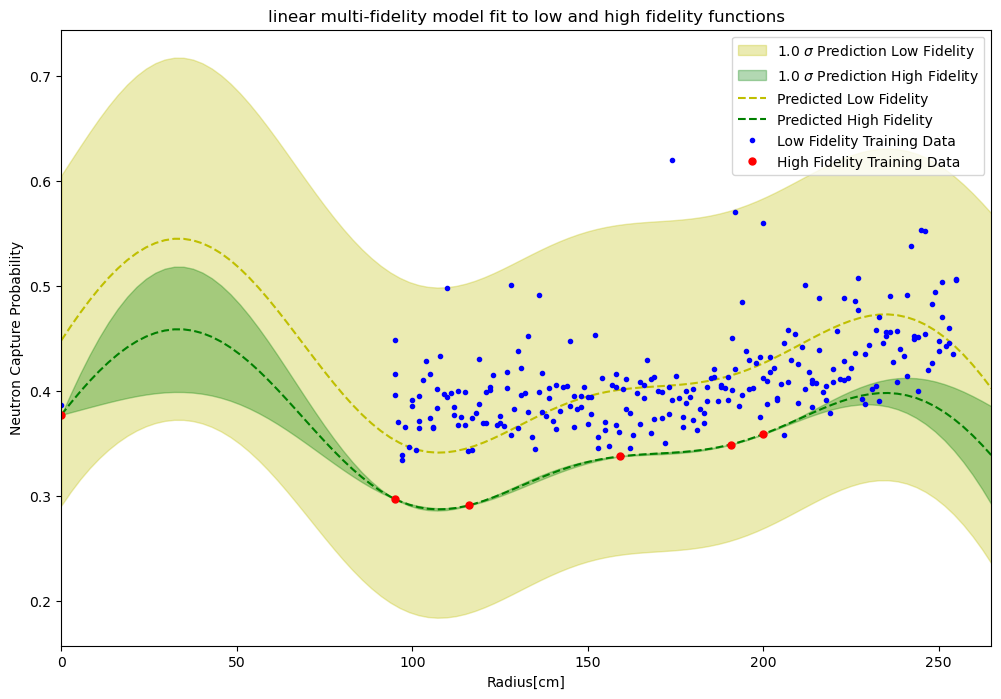

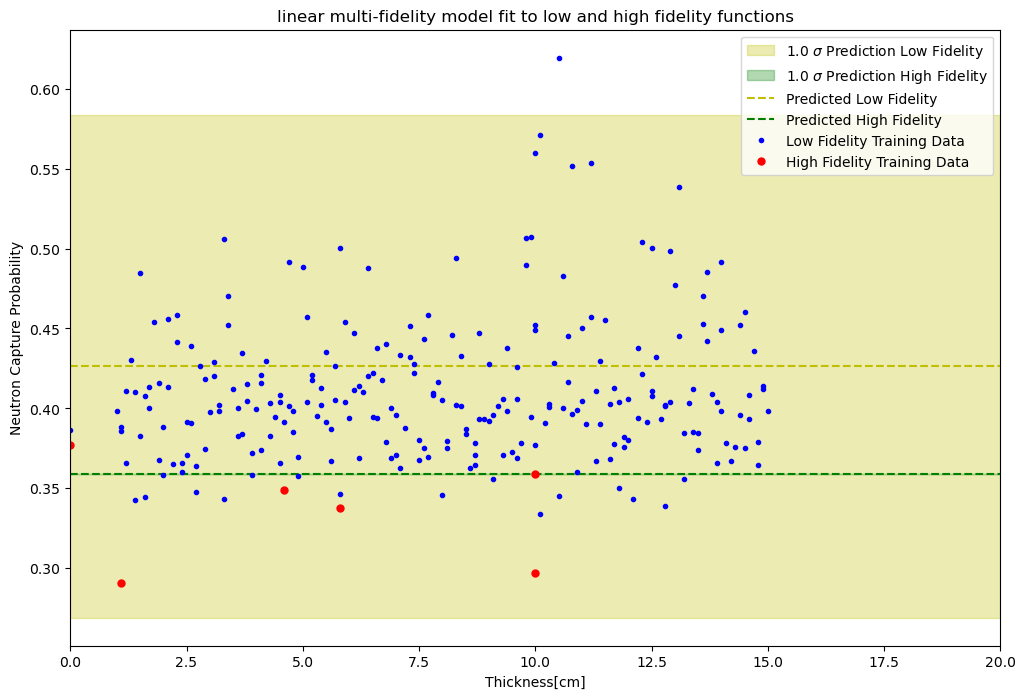

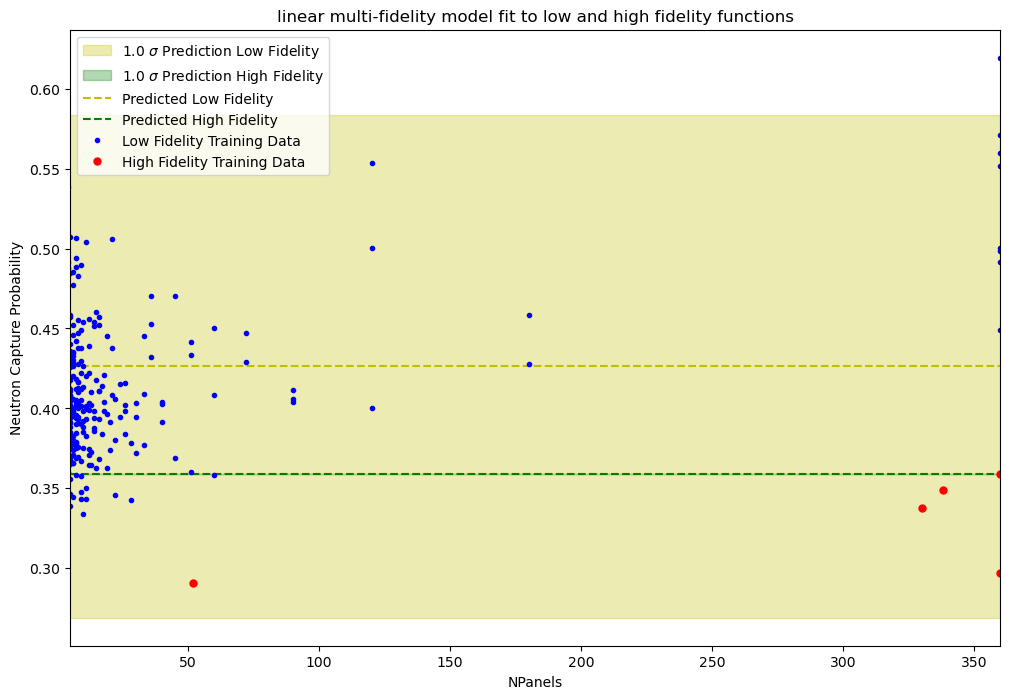

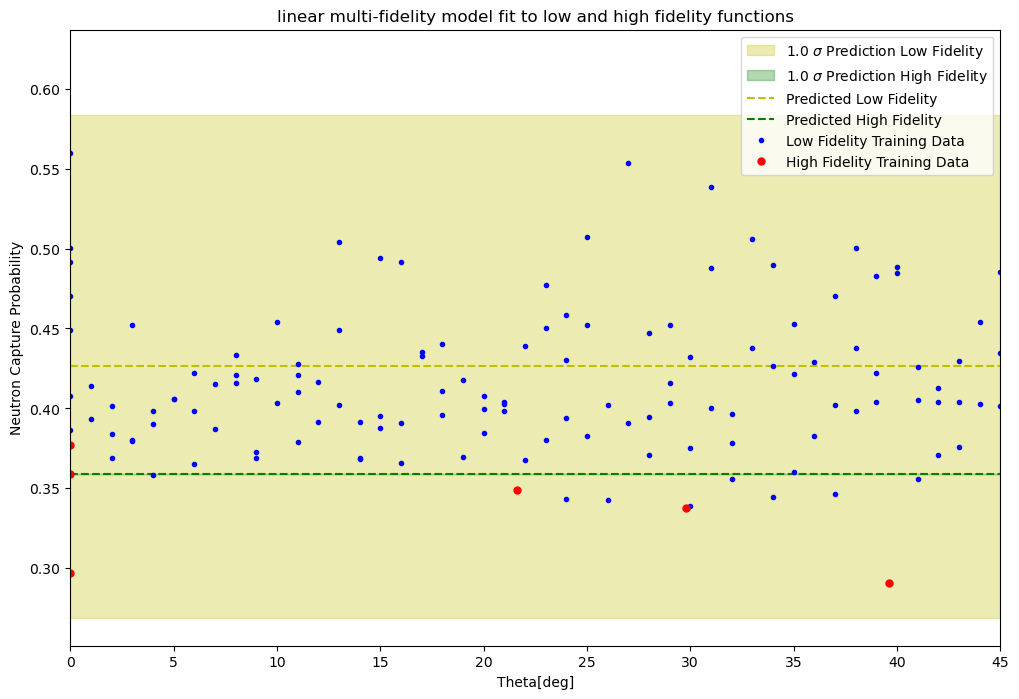

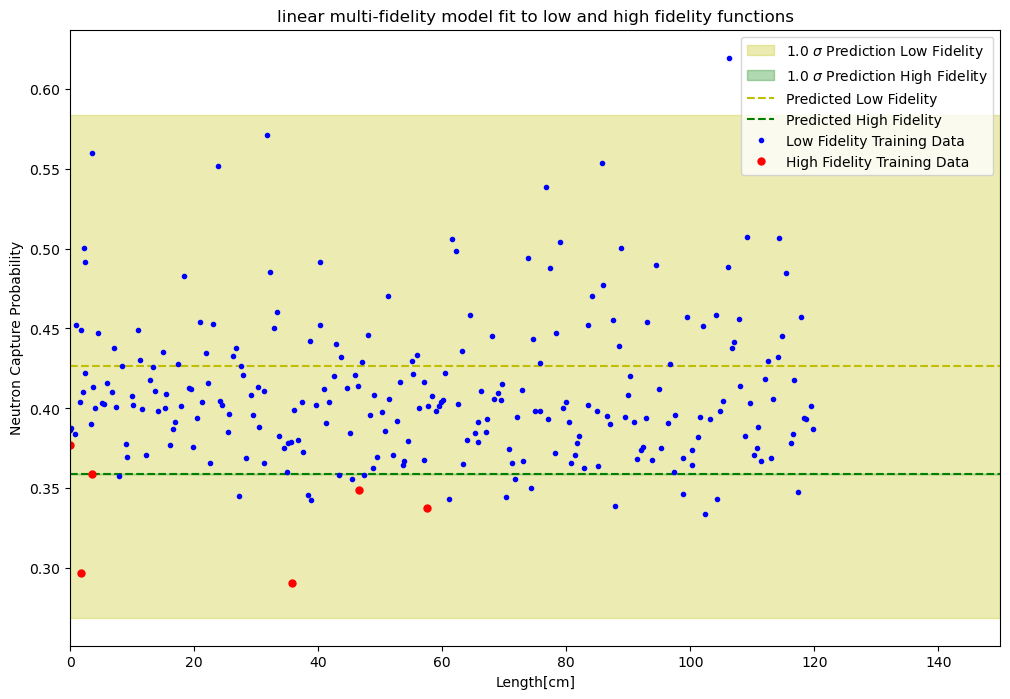

   Unnamed: 0  Sample  Mode  Radius[cm]  Thickness[cm]  NPanels  Theta[deg]   
0           0       0   1.0       221.4            7.8       35        22.1  \
1           1       0   0.0       221.4            7.8       35        22.1   
2           2       1   1.0       165.0           10.0      360         0.0   
3           2       1   0.0       165.0           10.0      360         0.0   

   Length[cm]  Ge-77[nevents]  Ge-77_CNP  Ge-77_CNP_err  
0       107.0             430      0.420          0.023  
1       107.0             100      0.500          0.023  
2         2.0             320      0.298          0.021  
3         2.0             320      0.500          0.021  
Sample # 1
   Unnamed: 0  Sample  Mode  Radius[cm]  Thickness[cm]  NPanels  Theta[deg]   
0           0       0   1.0       221.4            7.8       35        22.1  \
1           1       0   0.0       221.4            7.8       35        22.1   
2           2       1   1.0       165.0           10.0      360   

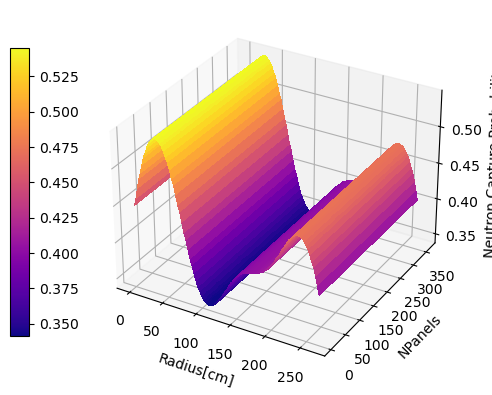

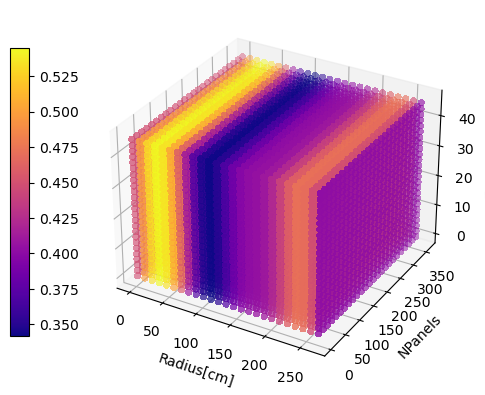

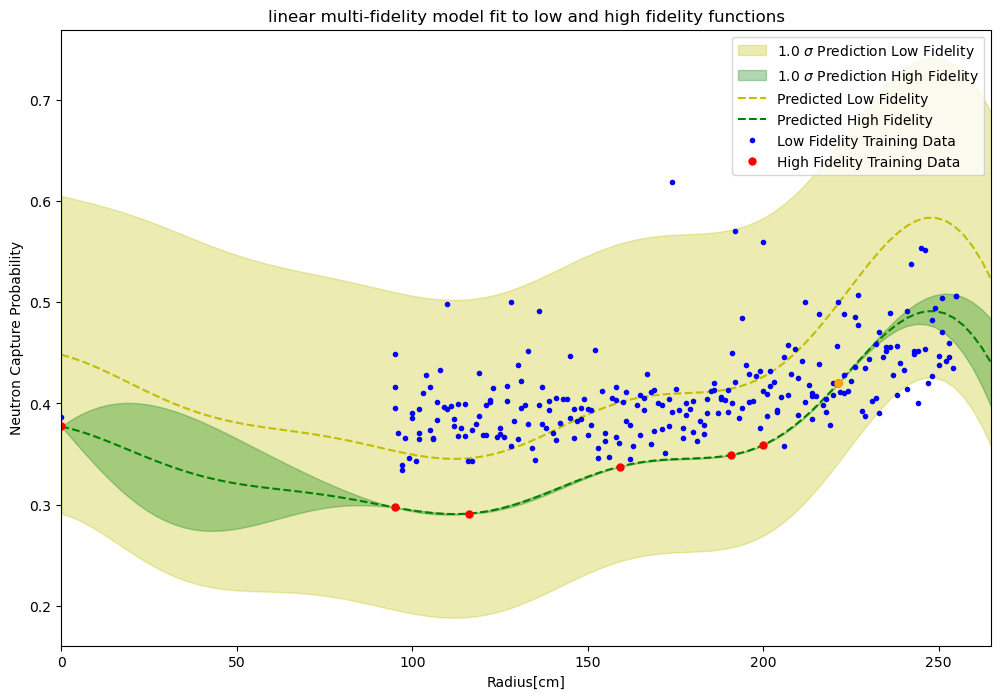

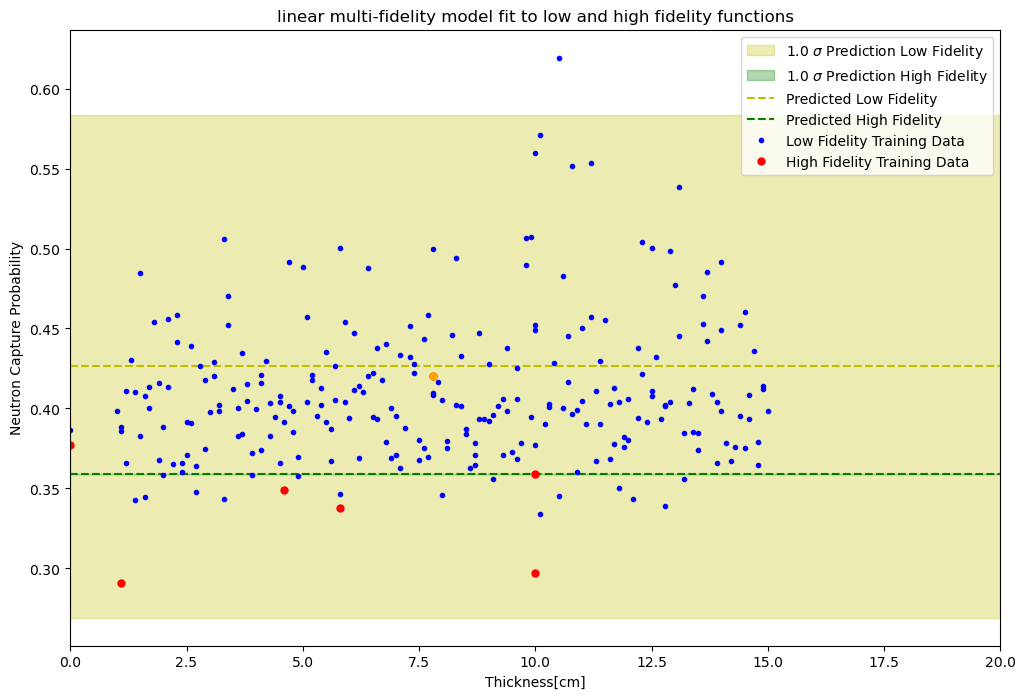

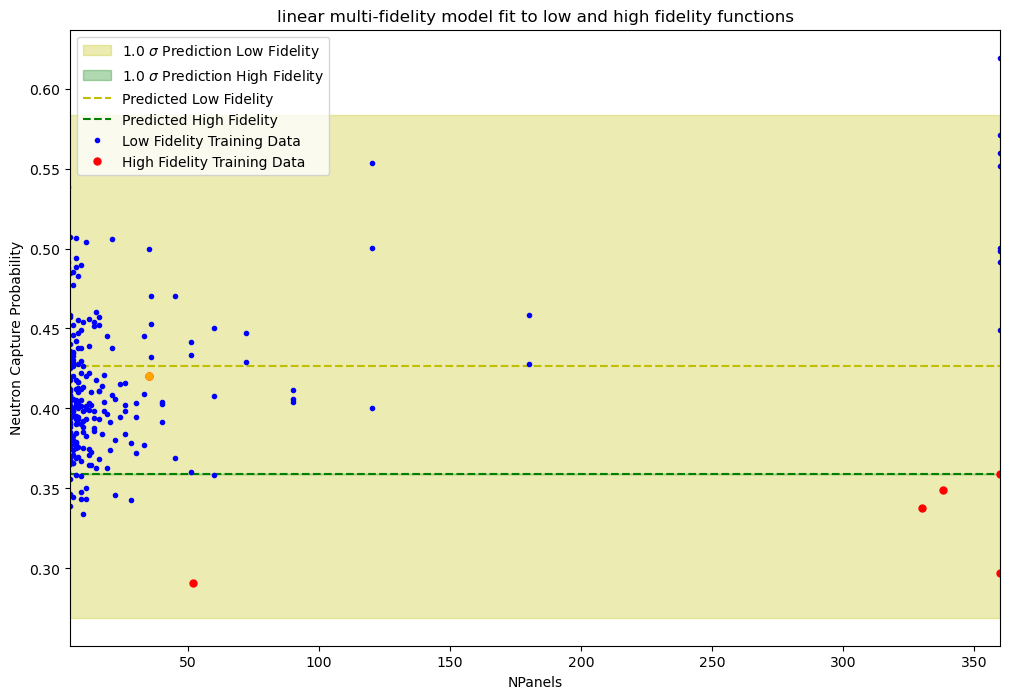

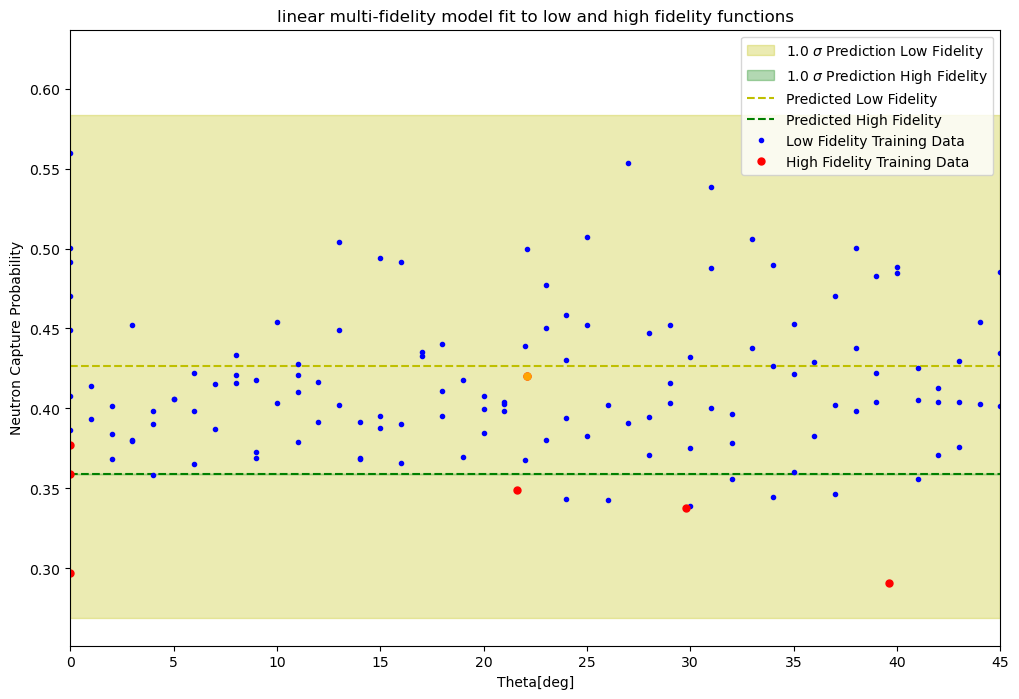

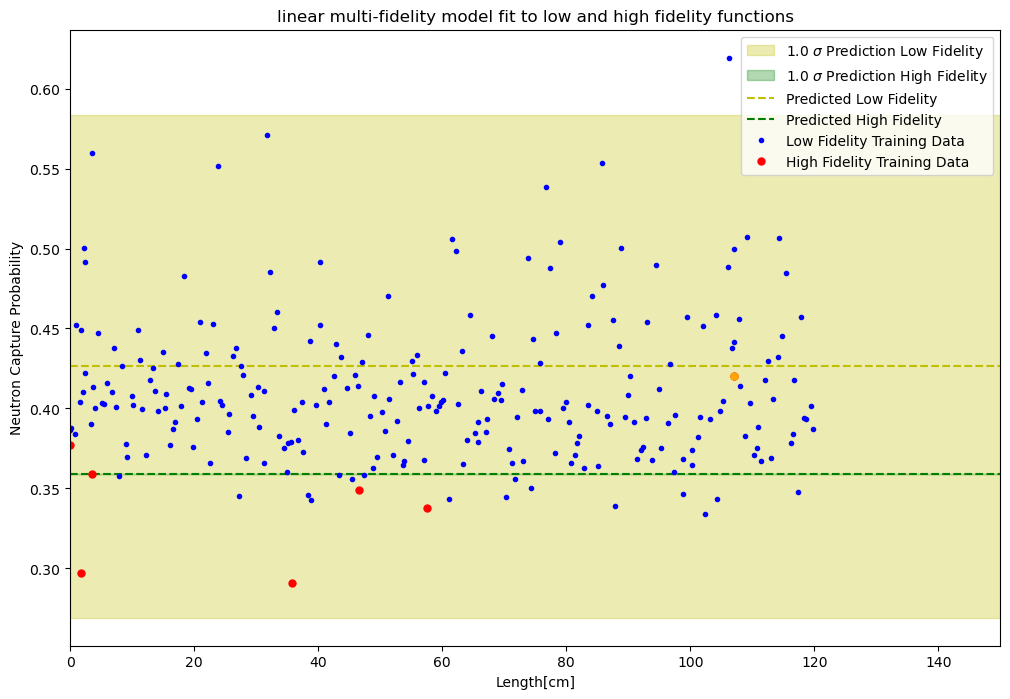

   Unnamed: 0  Sample  Mode  Radius[cm]  Thickness[cm]  NPanels  Theta[deg]   
0           0       0   1.0       221.4            7.8       35        22.1  \
1           1       0   0.0       221.4            7.8       35        22.1   
2           2       1   1.0       165.0           10.0      360         0.0   
3           2       1   0.0       165.0           10.0      360         0.0   

   Length[cm]  Ge-77[nevents]  Ge-77_CNP  Ge-77_CNP_err  
0       107.0             430      0.420          0.023  
1       107.0             100      0.500          0.023  
2         2.0             320      0.298          0.021  
3         2.0             320      0.500          0.021  
Sample # 2
   Unnamed: 0  Sample  Mode  Radius[cm]  Thickness[cm]  NPanels  Theta[deg]   
0           0       0   1.0       221.4            7.8       35        22.1  \
1           1       0   0.0       221.4            7.8       35        22.1   
2           2       1   1.0       165.0           10.0      360   

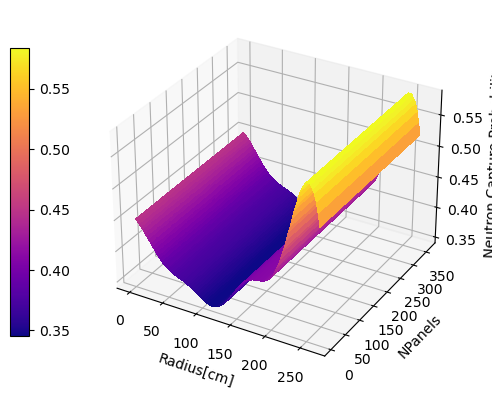

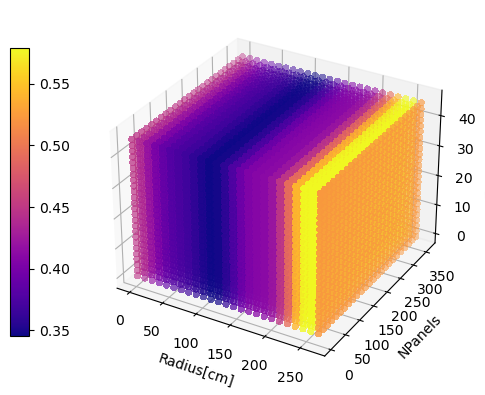

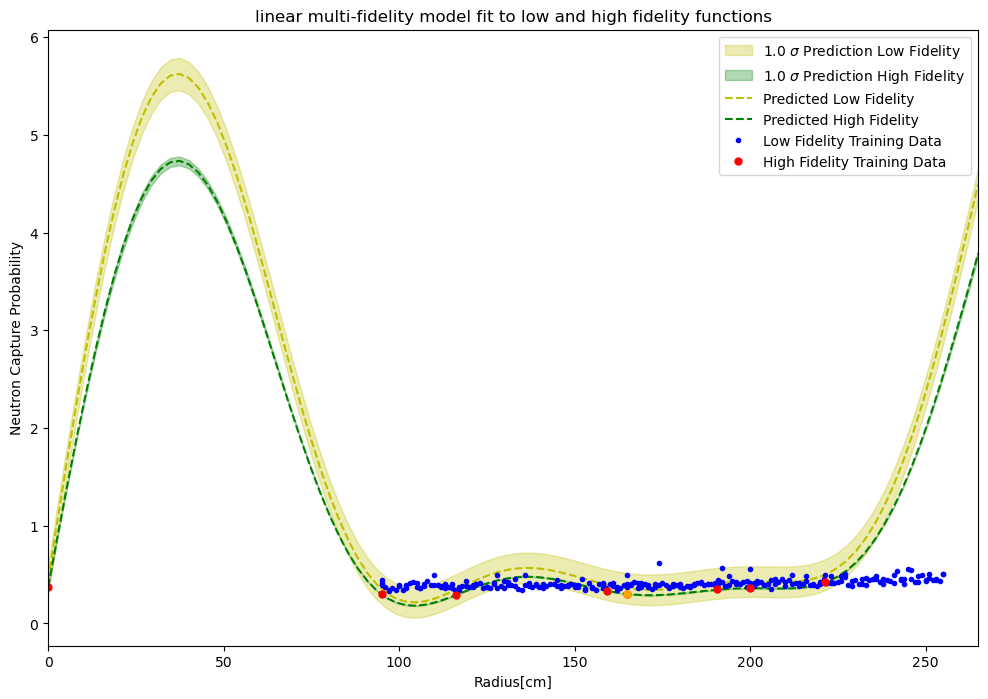

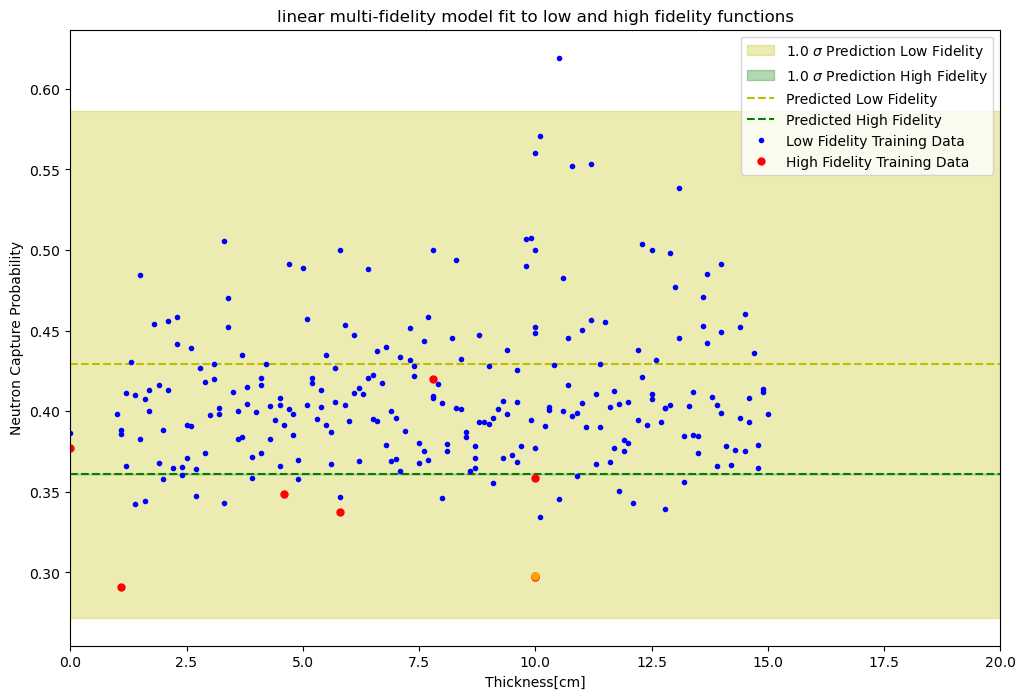

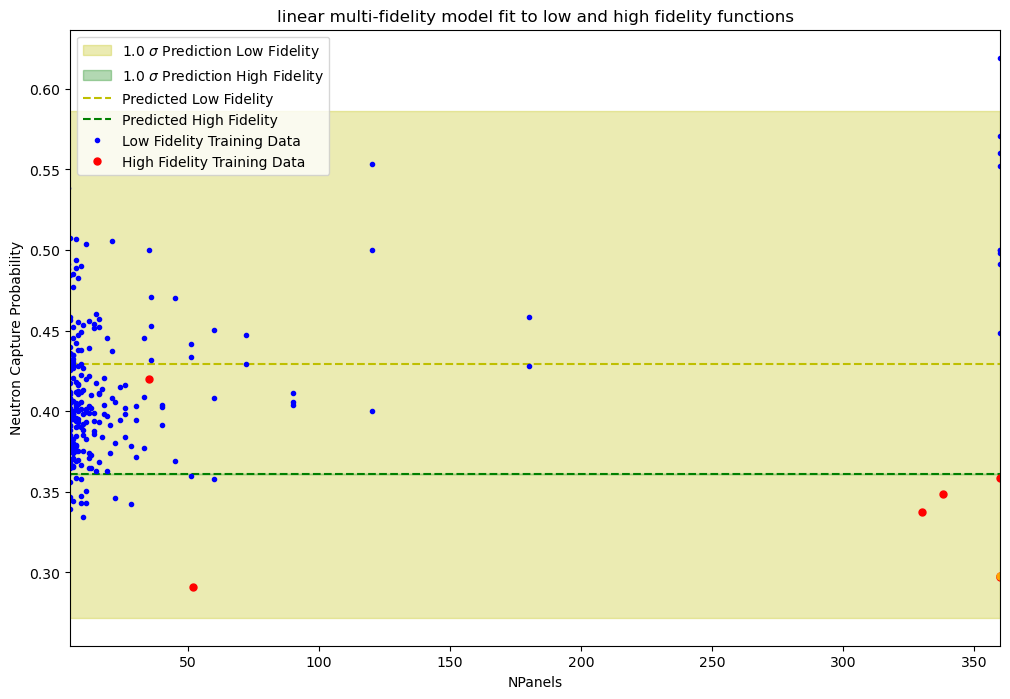

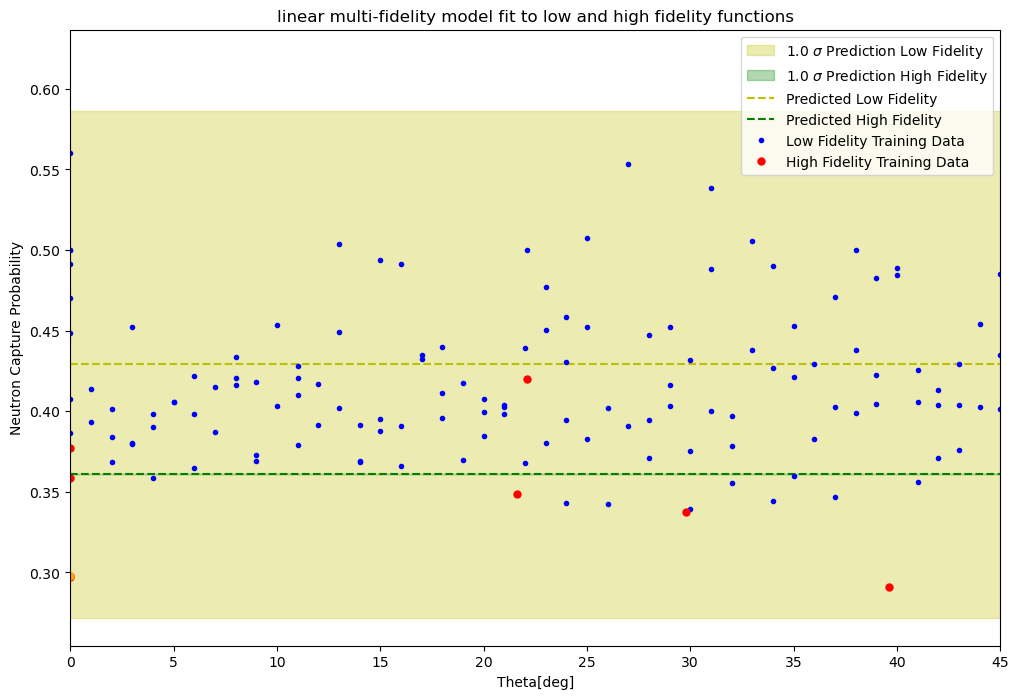

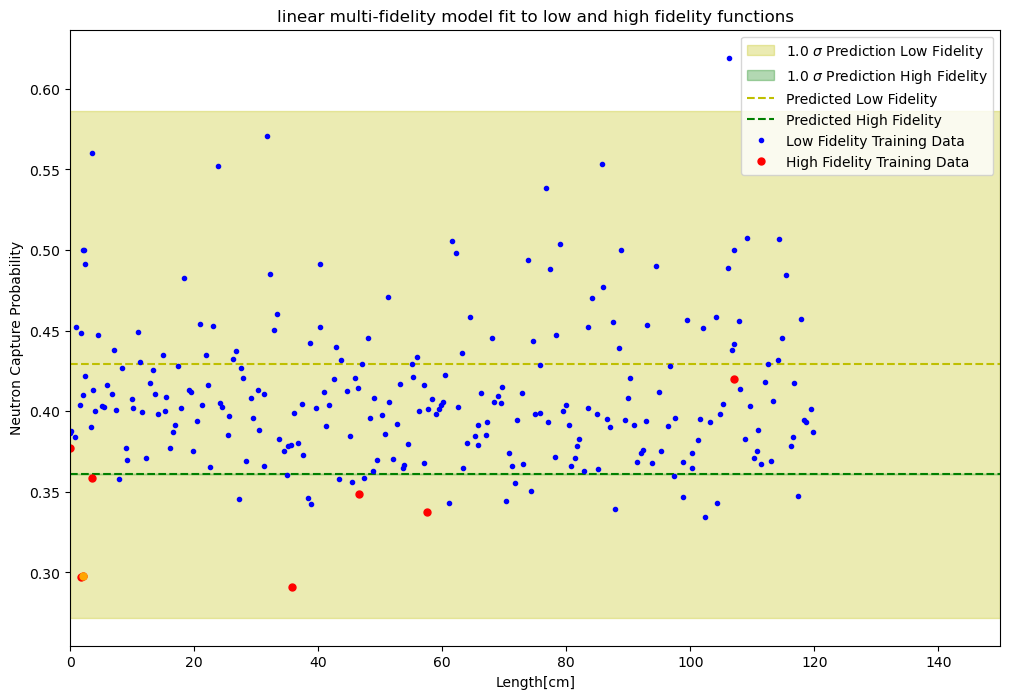

   Unnamed: 0  Sample  Mode  Radius[cm]  Thickness[cm]  NPanels  Theta[deg]   
0           0       0   1.0       221.4            7.8       35        22.1  \
1           1       0   0.0       221.4            7.8       35        22.1   
2           2       1   1.0       165.0           10.0      360         0.0   
3           2       1   0.0       165.0           10.0      360         0.0   

   Length[cm]  Ge-77[nevents]  Ge-77_CNP  Ge-77_CNP_err  
0       107.0             430      0.420          0.023  
1       107.0             100      0.500          0.023  
2         2.0             320      0.298          0.021  
3         2.0             320      0.500          0.021  


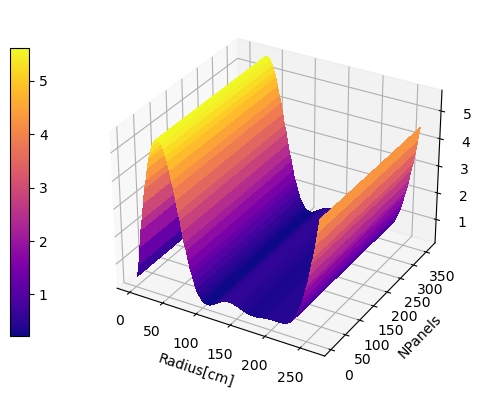

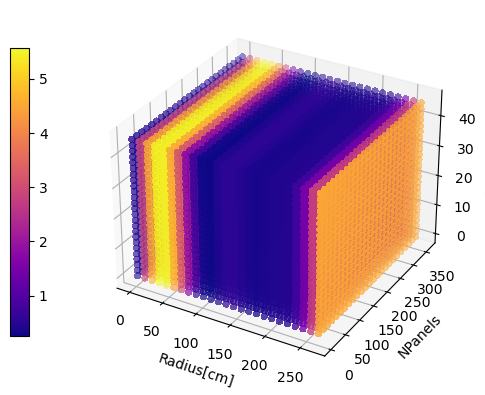

In [28]:
add_new_sample=True
sample=0
total_samples=20

while ( sample < total_samples and sample <= mfsm.GetNumberOfNewSamples(version)[0] ):
#while ( sample < total_samples and sample <= 4 ):
    print('Sample #', sample)
    #if  sample < mfsm.GetNumberOfNewSamples(version)[0]:
    mf_model, fig1, fig2 = mfsm.ActiveLearning(x_train_l, y_train_l, x_train_h, y_train_h, mf_model, xmin, xmax, xlow, xhigh, labels, factor, fig1, fig2, version, x_fixed, sample)
    leg_label.extend([f"updated acquisition func ({sample})",r'$x_{new}$'])
    sample+=1


In [ ]:
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

def DrawModelAcquisitionFunction(fig1, fig2, labels, version='v1'):
    fig5 = [plt.figure(figsize=(12,8)) for i in range(len(labels))]
    with PdfPages(f'out/{version}/model-acquisition-evolution_{version}.pdf') as pdf:
        for index, label in enumerate(labels):
            ax0=fig1[index].gca()
            ax1=fig2[index].gca()
            ncurves_per_fig_update=5
            nsamples=int((len(ax0.lines)+1)/ncurves_per_fig_update)
            
            fig5[index],(ax20,ax21)=plt.subplots(nrows=2,ncols=1,sharex=True)
            ax20.set_ylabel('Neutron Capture Probability')
            ax21.set_ylabel('a(x)')
            ax21.set_ylim(0,0.07)
            ax21.set_xlabel(label)
            ax20.grid(color='lightgray', linestyle='-', linewidth=0.5)
            ax21.grid(color='lightgray', linestyle='-', linewidth=0.5)
            colors=['blue','cyan','deepskyblue','midnightblue','teal','slategray', 'blueviolet','aquamarine','dodgerblue']
            #colors1=['green','darkred','red','blue','sienna','tomato','orangered','indianred','firebrick']
            print(len(ax0.collections))
            for i in range(len(ax0.collections)):
                
                if ax0.collections[i].get_alpha()==0.2:
                    poly=ax0.collections[i]
                    x1=poly.get_paths()[0].vertices
                    x1s=x1[:,0]
                    split=int((len(x1s)-1)/2)
                    x1s=x1s[:split]
                    y1s=x1[:split,1]
                    x2=poly.get_paths()[0].vertices
                    y2s=x2[split+1:,1]
                    y2s=y2s[::-1]
                    ax20.fill_between(x1s.flatten(),y1s.flatten(),y2s.flatten(),color='green',alpha=0.2)
            print(nsamples)
            for i in range(nsamples):
                idx=1
                if i > 0 :
                        idx=(ncurves_per_fig_update-1)+ncurves_per_fig_update*(i-1)+1
                curve0=ax0.lines[idx]
                ax20.plot(curve0.get_xdata(),curve0.get_ydata(),'--',color='green')
                if len(ax1.lines) > 0 :
                    curve1=ax1.lines[2*i]
                    y=curve1.get_ydata()/np.sum(curve1.get_ydata())
                    ax21.plot(curve1.get_xdata(),y,color=colors[i])
                    ymax=np.max(y)
                    xmax=np.argmax(y)
                    if i < nsamples-1:
                        idx=(ncurves_per_fig_update-1)+ncurves_per_fig_update*(i)+4
                        curve_tmp=ax0.lines[idx]
                        x=curve_tmp.get_xdata()
                        ax21.scatter(x,ymax,color=colors[i])
                    else:
                        curve2=ax1.lines[2*i+1]
                        ax21.plot(curve2.get_xdata(),curve2.get_ydata(), '--', color='lightgray')

            curve0=ax0.lines[len(ax0.lines)-1]

            ax20.plot(curve0.get_xdata()[0:3],curve0.get_ydata()[0:3],'o', color='black')
            print(len(curve0.get_xdata()))
            for i in range(3,len(curve0.get_xdata())):
                ax20.plot(curve0.get_xdata()[i],curve0.get_ydata()[i],'o',color=colors[i-3])
            pdf.savefig(fig5[index])
            plt.show()

In [ ]:
DrawModelAcquisitionFunction(fig1,fig2,labels,version)

TypeError: 'Axes3D' object is not subscriptable

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>